In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
!pip install netcdf4
!pip install ruptures
!pip install geopandas
!pip install rioxarray
!pip install pymannkendall
!pip install xclim
!pip install rasterio
!pip install salem

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import ruptures as rpt
import scipy.stats as stats
import matplotlib.pyplot as plt
import rioxarray
from geopandas import read_file as gpd_read_file
import pymannkendall as mk
import xclim
import pylab as pl
import seaborn as sns
import zipfile
import geopandas as gpd
import salem
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [11]:
shp_Peru = gpd_read_file("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/shapefile/shapefiles_peru/Departamentos.shp")

In [8]:
def xr_crop(shp_i, netcdf_i):

  # get box
  box_i = shp_i.total_bounds

  # crop based on box
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True)

  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):

  # get real box
  shp_i_geometry = shp_i.geometry

  # adding crs
  mask = netcdf_array.rio.set_crs(shp_i.crs)

  # "rasterizing"
  mask = mask.rio.clip(shp_i_geometry, drop = False)

  # making "True/False" values
  mask.values[~np.isnan(mask.values)] = 1

  return mask.drop(["time", "spatial_ref"])


def xr_mask(grid_mask, netcdf_i):

  # masking
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [5]:
PISCOp = xr.open_dataset("/content/drive/MyDrive/PROGRAMACIÓN_2/DATA/data.nc")
PISCOp = PISCOp.rename({"X":"longitude","Y":"latitude","T":"time"})
PISCOp["time"] = pd.date_range(start="1981-01-01T12:00:00.000000000",freq="24H", periods= 13149)
PISCOp

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 198, longitude: 133)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    Prec       (time, latitude, longitude) float32 ...

In [10]:
loreto = shp_Peru.iloc[[15]]

In [13]:
PISCOpp_crop = xr_crop(shp_i=loreto, netcdf_i=PISCOp)

In [17]:
shp_exp_grid = xr_shp_to_grid(shp_i = loreto,
                              netcdf_array = PISCOpp_crop.Prec)


PISCOp_crop_masked = xr_mask(grid_mask = shp_exp_grid,
                             netcdf_i = PISCOpp_crop)

HALLANDO LOS INDICES

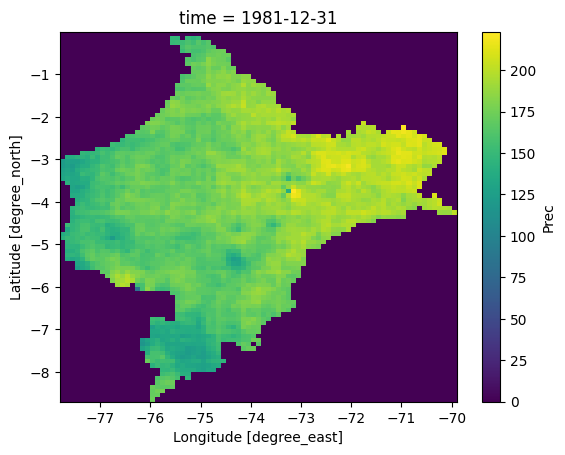

In [18]:
#R1mm
R1mm = lambda da: (da >= 1).resample(time = 'Y').sum()
R1mm(PISCOp_crop_masked.Prec).isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


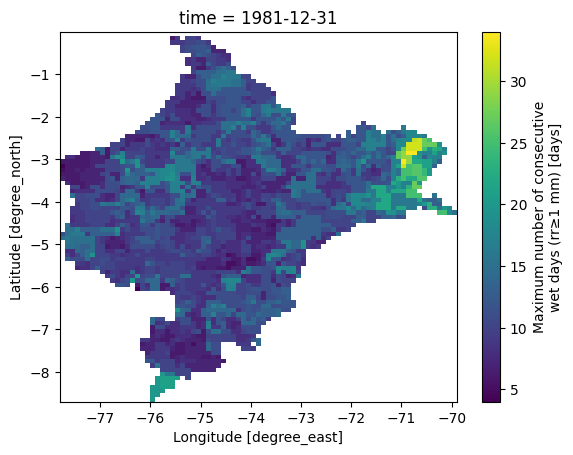

In [19]:
#CWD (Max consecutive wet days)
CWD = xclim.indicators.icclim.CWD(PISCOp_crop_masked.Prec, freq='Y', resample_before_rl=True, ds=None)
CWD.isel(time=0).plot()

In [20]:
#CWDm (Mean consecutive wet days)
def count_consecutive(da, tresh = 1, acum_type = 'greater than'):
    count = 0; overall_counter = []
    for i, j in enumerate(da):
        if acum_type == 'greater than':             count = count + 1 if da[i] > tresh else 0
        elif acum_type=='greater or equal than':    count = count + 1 if da[i] >= tresh else 0
        elif acum_type=='minor than':               count = count + 1 if da[i] < tresh else 0
        elif acum_type=='minor or equal than':      count = count + 1 if da[i] <= tresh else 0

        overall_counter.append(count)
    return np.nanmean(overall_counter)

In [21]:
PISCOp_crop_masked.resample(time = 'Y').count().copy()* np.nan

<xarray.Dataset>
Dimensions:    (latitude: 87, longitude: 79, time: 36)
Coordinates:
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
  * time       (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2016-12-31
Data variables:
    Prec       (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [22]:
def CWD(da):
    DA = da.resample(time = 'Y').count().copy()* np.nan
    for idx, g in da.resample(time = 'Y').groups.items():
        count = 0; overall_counter = []
        da_g = da.isel(time = g)

        DA.loc[idx] = xr.apply_ufunc(count_consecutive,
                                    da_g, 1., 'greater or equal than',
                                    input_core_dims = [['time'],[],[]],
                                    vectorize = True)
    #return DA.mean("time.year").round(0),DA.max()
    return DA

CWDm = CWD(PISCOp_crop_masked.Prec)

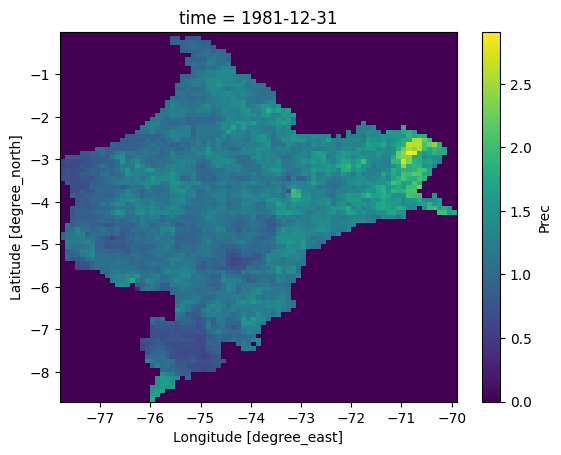

In [23]:
CWDm.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


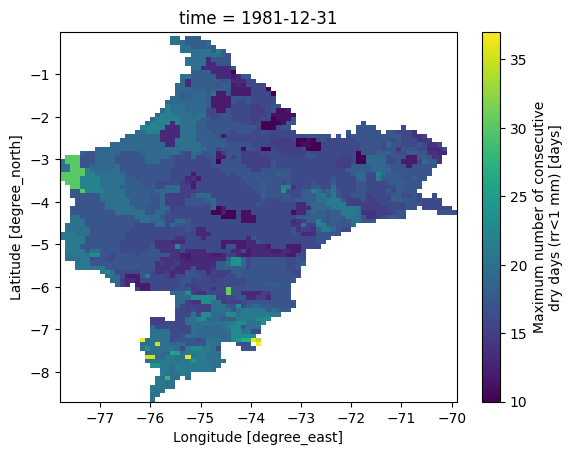

In [24]:
#CDD (Max consecutive dry days)
CDD = xclim.indicators.icclim.CDD(PISCOp_crop_masked.Prec, freq='Y', resample_before_rl=True, ds=None)
CDD.isel(time=0).plot()

In [25]:
#CDDm (Mean consecutive dry days)
def count_consecutive(da, tresh=1, acum_type='greater than'):
    count = 0
    overall_counter = []
    for i, j in enumerate(da):
        if acum_type == 'greater than':
            count = count + 1 if da[i] > tresh else 0
        elif acum_type == 'greater or equal than':
            count = count + 1 if da[i] >= tresh else 0
        elif acum_type == 'minor than':
            count = count + 1 if da[i] < tresh else 0
        elif acum_type == 'minor or equal than':
            count = count + 1 if da[i] <= tresh else 0

        overall_counter.append(count)
    return np.nanmean(overall_counter)

In [26]:
PISCOp_crop_masked.resample(time = 'Y').count().copy()* np.nan

<xarray.Dataset>
Dimensions:    (latitude: 87, longitude: 79, time: 36)
Coordinates:
  * latitude   (latitude) float32 -0.05 -0.15 -0.25 -0.35 ... -8.45 -8.55 -8.65
  * longitude  (longitude) float32 -77.75 -77.65 -77.55 ... -70.15 -70.05 -69.95
  * time       (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2016-12-31
Data variables:
    Prec       (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [27]:
def CDD(da):
    DA = da.resample(time = 'Y').count().copy() * np.nan
    for idx, g in da.resample(time = 'Y').groups.items():
        count = 0; overall_counter = []
        da_g = da.isel(time = g)

        DA.loc[idx] = xr.apply_ufunc(count_consecutive,
                                    da_g, 1., 'minor than',
                                    input_core_dims = [['time'],[],[]],
                                    vectorize = True)


    #return DA_season.mean().round(0), DA_season.max()
    return DA
CDDm = CDD(PISCOp_crop_masked.Prec)

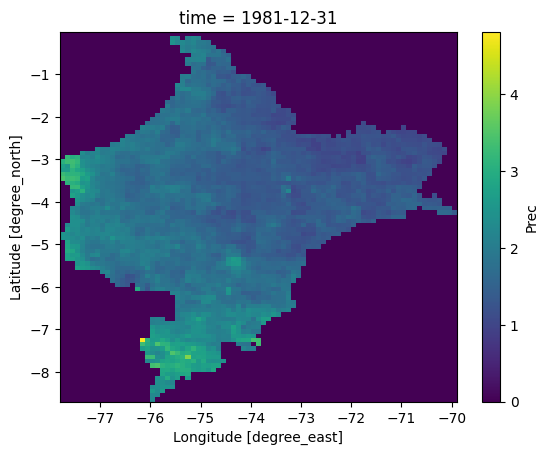

In [28]:
CDDm.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


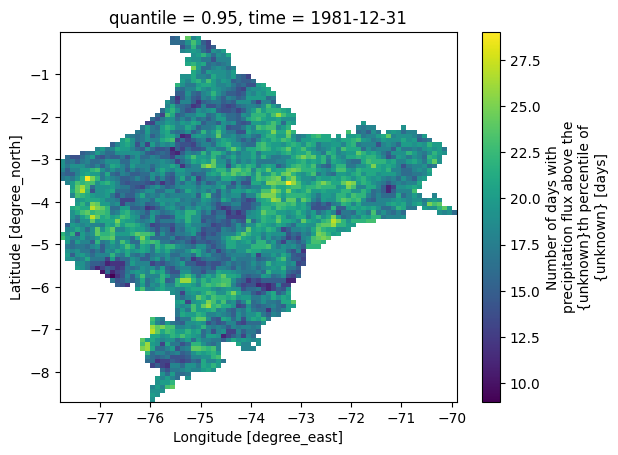

In [29]:
#R95p (Number of very wet days)
PISCOp_crop_masked.attrs['units'] = "mm/day"
Pisco_95 = PISCOp_crop_masked.Prec.quantile(0.95,dim="time")
Pisco_95.attrs["units"]="mm/day"

R95p = xclim.indicators.icclim.R95p(PISCOp_crop_masked.Prec,Pisco_95, freq='Y', bootstrap=False, op='>', ds=None)
R95p.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


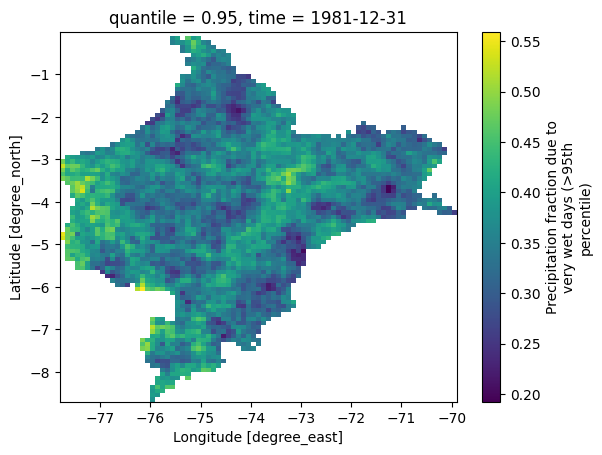

In [30]:
#R95pTOT (Total of very wet days)
PISCOp_crop_masked.attrs['units'] = "mm/day"
Pisco_95 = PISCOp_crop_masked.Prec.quantile(0.95,dim="time")
Pisco_95.attrs["units"]="mm/day"

R95pTOT=xclim.indicators.icclim.R95pTOT(PISCOp_crop_masked.Prec, Pisco_95, freq='Y', bootstrap=False, op='>', ds=None)
R95pTOT.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


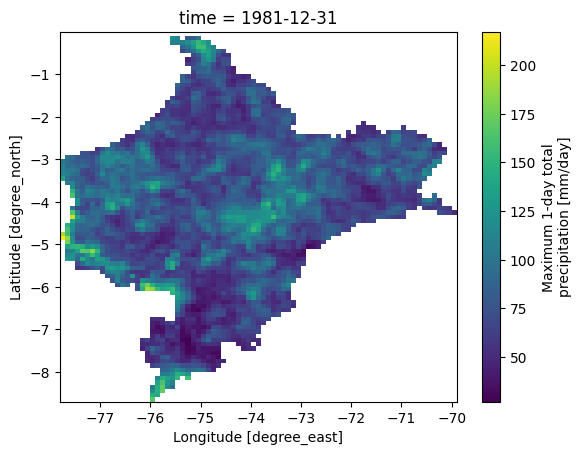

In [31]:
#Rx1day (Max 1-day precipitation)
RX1day = xclim.indicators.atmos.max_1day_precipitation_amount(PISCOp_crop_masked.Prec,freq='Y',ds=None)
RX1day.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


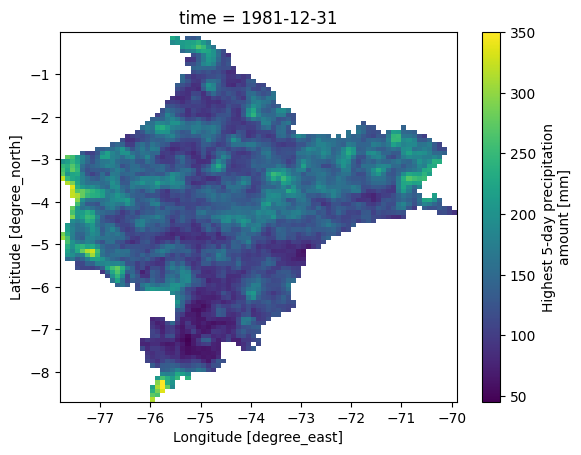

In [32]:
#Rx5day (Max 5-day precipitation)
RX5day = xclim.indicators.icclim.RX5day(PISCOp_crop_masked.Prec,freq='Y',ds=None)
RX5day.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


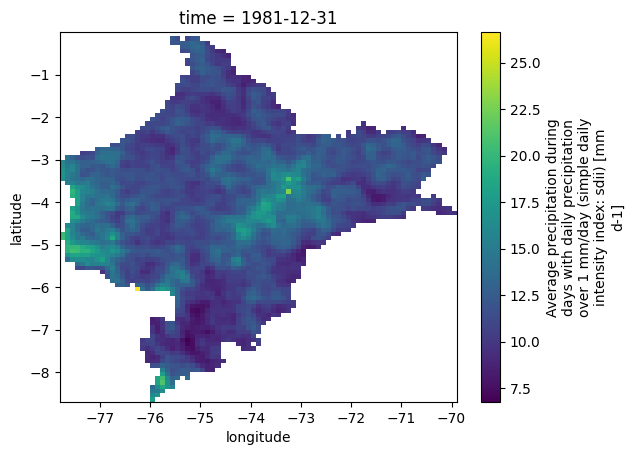

In [33]:
#SDII (Simple daily intensity index)
SDII = xclim.indicators.icclim.SDII(PISCOp_crop_masked.Prec, freq='Y', op='>=', ds=None)
SDII.isel(time=0).plot()

/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/usr/local/lib/python3.10/dist-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


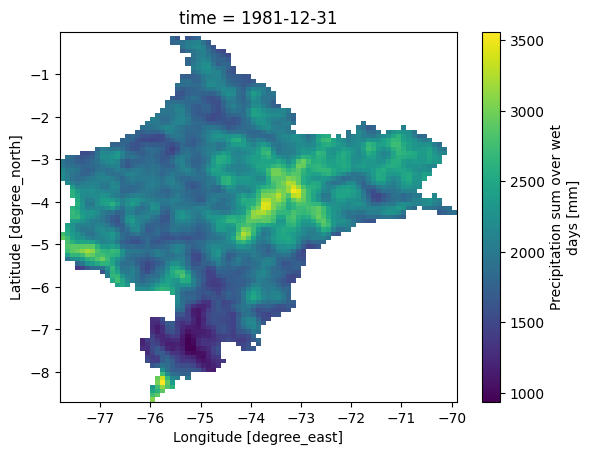

In [34]:
#PRCPTOT (Total precipitation)
PRCPTOT = xclim.indicators.icclim.PRCPTOT(PISCOp_crop_masked.Prec, freq='Y', ds=None)
PRCPTOT.isel(time=0).plot()